In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn import datasets
from dbc.main import KmeansDiscreteMinmaxClassifier, CmeansDiscreteBayesianClassifier
from dbc.utils import compute_class_conditional_risk_with_labels
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
# 存储两种方法的风险值
num=100
risks_DMC = np.zeros([num, 2])
risks_SPDBC = np.zeros([num, 2])

# 重复100次
for i in range(num):
    # Generate data
    X, y = datasets.make_blobs(
        n_samples= [125 * 5 , 125 * 2],
        n_features=2,
        centers=[(9.5, 10), (10, 9.4)],
        cluster_std=[[0.6, 0.6], [0.35, 0.3]],
        shuffle=True,
    )

    # 分割数据集，test_size=0.2表示测试集占20%
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,  # 测试集比例
        random_state=43,  # 随机种子，确保结果可重现
        stratify=y  # 保持分割后各类别的比例与原始数据集一致
    )

    # 添加噪音
    X_train_noise = X_train + np.random.normal(0, 0, size=X_train.shape)
    X_test_noise = X_test + np.random.normal(0, 0, size=X_test.shape)

    DMC = KmeansDiscreteMinmaxClassifier(n_clusters=15)
    DMC.fit(X_train_noise, y_train)

    SPDBC = CmeansDiscreteBayesianClassifier(n_clusters=15, fuzzifier=2, cluster_centers=DMC.cluster_centers)
    SPDBC.fit(X_train_noise, y_train)

    # DMC预测和风险计算
    y_pred_DMC = DMC.predict(X_test_noise)
    risks_DMC[i, :] = compute_class_conditional_risk_with_labels(y_test, y_pred_DMC)[0]

    # SPDBC预测和风险计算
    # y_pred_SPDBC = SPDBC.predict(X_test_noise, prior_pred=np.array([0.6,0.4]))
    y_pred_SPDBC = SPDBC.predict(X_test_noise, prior_pred=np.array([0.555,0.445]))
    # y_pred_SPDBC = SPDBC.predict(X_test_noise, prior_pred=DMC.prior_star)
    risks_SPDBC[i, :] = compute_class_conditional_risk_with_labels(y_test, y_pred_SPDBC)[0]



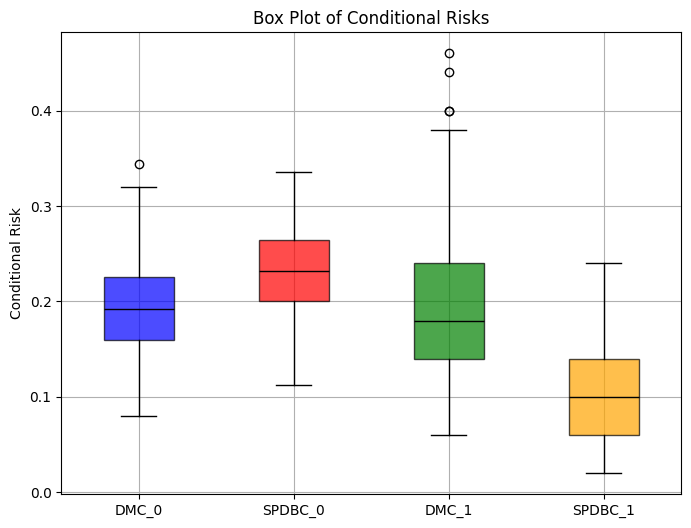

In [3]:
# 箱线图
plt.figure(figsize=(8, 6))
box_parts = plt.boxplot([risks_DMC[:, 0], risks_SPDBC[:, 0], risks_DMC[:, 1], risks_SPDBC[:, 1]],
                        patch_artist=True)  # patch_artist=True 允许我们填充箱体颜色

# 自定义颜色和样式
colors = ['blue', 'red', 'green', 'orange']
for patch, color in zip(box_parts['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# 设置其他元素的颜色
plt.setp(box_parts['medians'], color='black')  # 中位数线
plt.setp(box_parts['whiskers'], color='black')  # 须线
plt.setp(box_parts['caps'], color='black')  # 须线端点
plt.setp(box_parts['fliers'], color='black')  # 异常值点

plt.xticks([1, 2, 3, 4], ['DMC_0', 'SPDBC_0', 'DMC_1', 'SPDBC_1'])
plt.ylabel('Conditional Risk')
plt.title('Box Plot of Conditional Risks')
plt.grid(True)
plt.show()


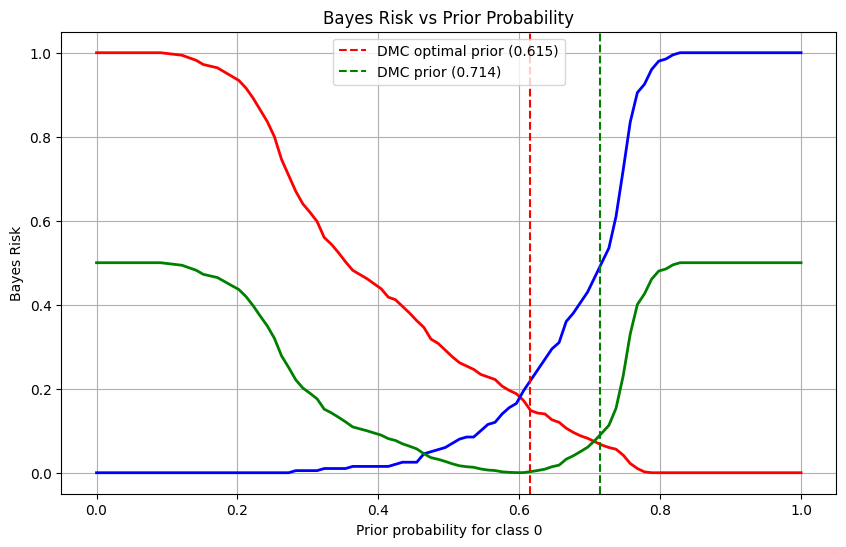

In [4]:
import numpy as np
import matplotlib.pyplot as plt

SPDBC = CmeansDiscreteBayesianClassifier(
    n_clusters=15,
    fuzzifier=2,
    cluster_centers=DMC.cluster_centers,
)
SPDBC.fit(X_train, y_train)
DMC = KmeansDiscreteMinmaxClassifier(n_clusters=15)
DMC.fit(X_train, y_train)
# 创建prior_pred矩阵
prior_values = np.linspace(0, 1, 100)  # 生成0到1之间的100个值
prior_pred = np.zeros((100, 2))
prior_pred[:, 0] = prior_values
prior_pred[:, 1] = 1 - prior_values  # 确保每行和为1

# 计算不同prior下的风险
risks = np.zeros((100, 2))
for i in range(100):
    y_pred = SPDBC.predict(X_train, prior_pred=prior_pred[i, :].reshape(1, -1))
    # y_pred = DMC.predict(X_train, prior_pred=prior_pred[i, :].reshape(1, -1))
    risk = compute_class_conditional_risk_with_labels(y_train, y_pred)
    risks[i,:] = risk[0]

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(prior_values, risks[:,0], 'r-', linewidth=2)
plt.plot(prior_values, risks[:,1], 'b-', linewidth=2)
r = (risks[:,0]+ risks[:,1])/2
# r= prior_pred[:, 1]*risks[:,1]+prior_pred[:, 0]*risks[:,0]

# plt.plot(prior_values, prior_pred[:, 1]*risks[:,1]+prior_pred[:, 0]*risks[:,0], 'g-', linewidth=2)
plt.plot(prior_values, (risks[:,1] - r)**2 + (risks[:,0] - r)**2, 'g-', linewidth=2)
# plt.plot(prior_values, abs(risks[:,1] - r) + abs(risks[:,0] - r), 'g-', linewidth=2)
plt.xlabel('Prior probability for class 0')
plt.ylabel('Bayes Risk')
plt.title('Bayes Risk vs Prior Probability')
plt.grid(True)
plt.axvline(x=DMC.prior_best[0, 0], color='r', linestyle='--',
            label=f'DMC optimal prior ({DMC.prior_best[0, 0]:.3f})')
plt.axvline(x=SPDBC.prior[0], color='g', linestyle='--',
            label=f'DMC prior ({SPDBC.prior[0]:.3f})')
plt.legend()
plt.show()

# # 找出最小风险对应的prior
# min_risk_idx = np.argmin(risks)
# print(f"最小风险对应的prior[0]: {prior_values[min_risk_idx]:.3f}")
# print(f"最小风险值: {risks[min_risk_idx]:.3f}")

In [5]:
dist = abs(risks[:,1] - r) + abs(risks[:,0] - r)

# 找出比前一个位置值大的索引
increases = np.where(dist[1:] > dist[:-1])[0] + 1

print("在以下索引位置处值上升:")
print(increases)

# 如果需要看具体的上升幅度
differences = dist[1:] - dist[:-1]
print("\n上升幅度:")
for idx in increases:
    print(f"索引 {idx}: 上升了 {differences[idx - 1]:.6f}")

在以下索引位置处值上升:
[60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82]

上升幅度:
索引 60: 上升了 0.000000
索引 61: 上升了 0.049000
索引 62: 上升了 0.031000
索引 63: 上升了 0.027000
索引 64: 上升了 0.039000
索引 65: 上升了 0.021000
索引 66: 上升了 0.064000
索引 67: 上升了 0.030000
索引 68: 上升了 0.033000
索引 69: 上升了 0.031000
索引 70: 上升了 0.043000
索引 71: 上升了 0.043000
索引 72: 上升了 0.041000
索引 73: 上升了 0.079000
索引 74: 上升了 0.124000
索引 75: 上升了 0.135000
索引 76: 上升了 0.082000
索引 77: 上升了 0.028000
索引 78: 上升了 0.037000
索引 79: 上升了 0.020000
索引 80: 上升了 0.005000
索引 81: 上升了 0.010000
索引 82: 上升了 0.005000


In [6]:
def compute_avg_prob(y_true, prob_pred):
    """
    计算每个类的平均预测概率

    参数:
    y_true: np.array - 真实标签
    prob_pred: np.array - 预测概率矩阵，shape为(n_samples, n_classes)

    返回:
    np.array - 每个类的平均预测概率
    """
    classes = np.unique(y_true)
    avg_probs = []

    for c in classes:
        # 找出属于当前类的样本索引
        class_mask = (y_true == c)
        # 计算当前类的平均预测概率
        class_avg_prob = np.mean(prob_pred[class_mask], axis=0)
        avg_probs.append(class_avg_prob)

    return np.array(avg_probs)


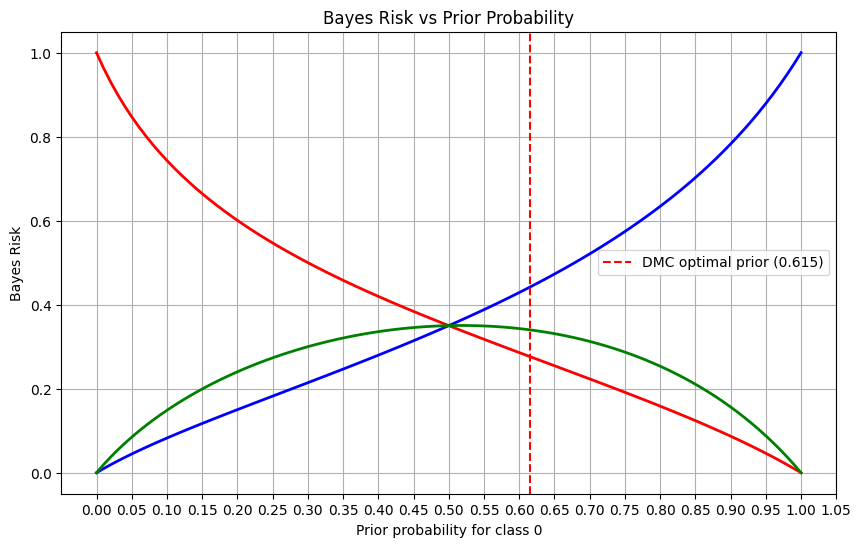

In [7]:
import numpy as np
import matplotlib.pyplot as plt

SPDBC = CmeansDiscreteBayesianClassifier(
    n_clusters=15,
    fuzzifier=2,
    cluster_centers=DMC.cluster_centers,
)
SPDBC.fit(X_train_noise, y_train)
# 创建prior_pred矩阵
prior_values = np.linspace(0, 1, 100)  # 生成0到1之间的100个值
prior_pred = np.zeros((100, 2))
prior_pred[:, 0] = prior_values
prior_pred[:, 1] = 1 - prior_values  # 确保每行和为1

# 计算不同prior下的风险
risks = np.zeros((100, 2))
for i in range(100):
    prob = SPDBC.predict_prob(X_train_noise, prior_pred=prior_pred[i,:].reshape(1, -1))
    risks[i,0] = compute_avg_prob(y_train, prob)[0,1]
    risks[i,1] = compute_avg_prob(y_train, prob)[1,0]


# 绘图
plt.figure(figsize=(10, 6))
plt.plot(prior_values, risks[:,0], 'r-', linewidth=2)
plt.plot(prior_values, risks[:,1], 'b-', linewidth=2)
plt.plot(prior_values, prior_pred[:, 1]*risks[:,1]+prior_pred[:, 0]*risks[:,0], 'g-', linewidth=2)
plt.xlabel('Prior probability for class 0')
plt.ylabel('Bayes Risk')
x_ticks = np.arange(0, 1.1, 0.05)
plt.xticks(x_ticks)
plt.title('Bayes Risk vs Prior Probability')
plt.grid(True)
plt.axvline(x=DMC.prior_best[0, 0], color='r', linestyle='--',
            label=f'DMC optimal prior ({DMC.prior_best[0, 0]:.3f})')
plt.legend()
plt.show()

# # 找出最小风险对应的prior
# min_risk_idx = np.argmin(risks)
# print(f"最小风险对应的prior[0]: {prior_values[min_risk_idx]:.3f}")
# print(f"最小风险值: {risks[min_risk_idx]:.3f}")

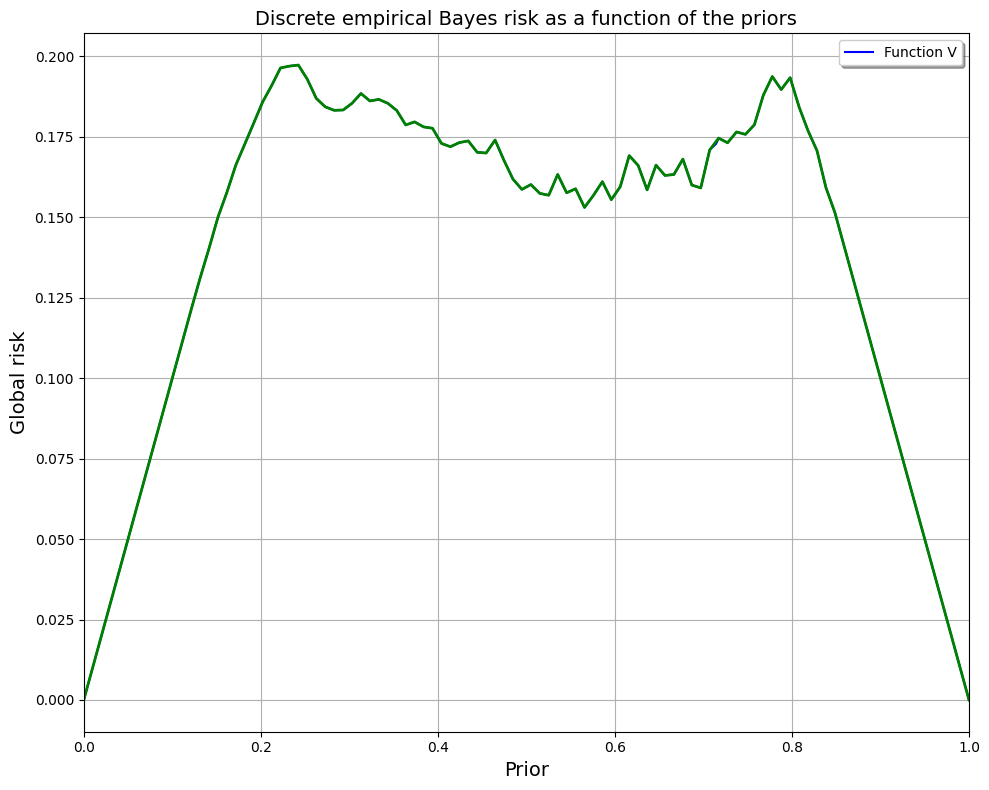

In [20]:
q qfre = np.unique(np.argmax(SPDBC.membership_degree.T, axis=1),return_counts=True)[1]
aa = np.unique(y_train,return_counts=True)[1]
def plot2D_V_piTrain_piBar(pHat, K, L, T, piTrain, piBar):
    '''
    param:pHat: probability estimate of observing the features profiles x_t in each class k
    param:K: number of classes
    param:L: loss function
    param:T: optimal number of centroids for the discretization process
    param:piTrain: class proportions on the training set
    param:piBar: least favorable priors
    return:rpiTrain: global risk on the training set
    return:rpiBar: V(piBar)
    '''

    xx = np.sort(np.insert(np.linspace(0,1,100), [2, 2], [piTrain[0,0], piBar[0,0]]))
    stock_pi = np.zeros((np.shape(xx)[0], K))
    stock_r = np.zeros((1, np.shape(xx)[0]))

    i = 0
    for x in xx:
        stock_pi[i,0] = x
        stock_pi[i,1] = 1 - x
        i = i + 1


    for i in range(0, np.shape(xx)[0]):
        for ii in range(X_train.shape[0]):
            lambd = np.zeros((K))
            for l in range(0, K):
                for t in range(0, T):
                    for k in range(0, K):
                            lambd[l] += L[k,l] * stock_pi[i,k] * pHat[k,t] * SPDBC.membership_degree.T[ii,t]
            for l in range(0, K):
                for k in range(0, K):
                    if lambd[l] == np.min(lambd) and y_train[ii] == k:
                        stock_r[0,i] += L[k,l] * stock_pi[i,k] / aa[k]




    # 图形绘制部分的修改
    plt.figure(figsize=(10, 8))
    plt.plot(xx, stock_r[0], color='blue', label='Function V')
    plt.plot(prior_values, prior_pred[:, 1]*risks[:,1]+prior_pred[:, 0]*risks[:,0], 'g-', linewidth=2)
    # plt.plot(xx, stock_r_piTrain, color='orange', label='Discrete Bayes Classifier')
    # plt.vlines(x=piTrain[0, 0], ymin=0, ymax=rpiTrain, linewidth=2, color='orange', linestyle="--")
    # plt.plot(xx, stock_r_piBar, color='green', label='Discrete Minimax Classifier')
    # plt.vlines(x=piBar[0, 0], ymin=0, ymax=rpiBar, linewidth=2, color='green', linestyle="--")

    # 设置字体和标题
    font = {'weight': 'normal', 'size': 14}
    plt.title('Discrete empirical Bayes risk as a function of the priors', fontdict=font)
    plt.xlabel('Prior', fontdict=font)
    plt.ylabel('Global risk', fontdict=font)

    plt.xlim(0, 1)
    # plt.ylim(0,1)
    plt.grid(True)
    plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()

    return lambd
lambd = plot2D_V_piTrain_piBar(SPDBC.p_hat, 2, SPDBC.loss_function, 15, SPDBC.prior.reshape(1,-1), SPDBC.prior.reshape(1,-1))

In [21]:
from dbc.utils import compute_class_conditional_risk,compute_global_risk
K=2
xx = np.linspace(0,1,100)
stock_pi = np.zeros((np.shape(xx)[0], K))
i = 0
for x in xx:
    stock_pi[i,0] = x
    stock_pi[i,1] = 1 - x
    i = i + 1
r = np.zeros(np.shape(xx)[0])
class_conditional_risk= np.zeros(K)
for i in range(0, np.shape(xx)[0]):
    for k in range(0, K):
        class_conditional_risk[k] = compute_class_conditional_risk(X_train, y_train, k, SPDBC.loss_function, SPDBC.p_hat, SPDBC.membership_degree, stock_pi[i, :])
    r[i] = compute_global_risk(class_conditional_risk,stock_pi[i,:])

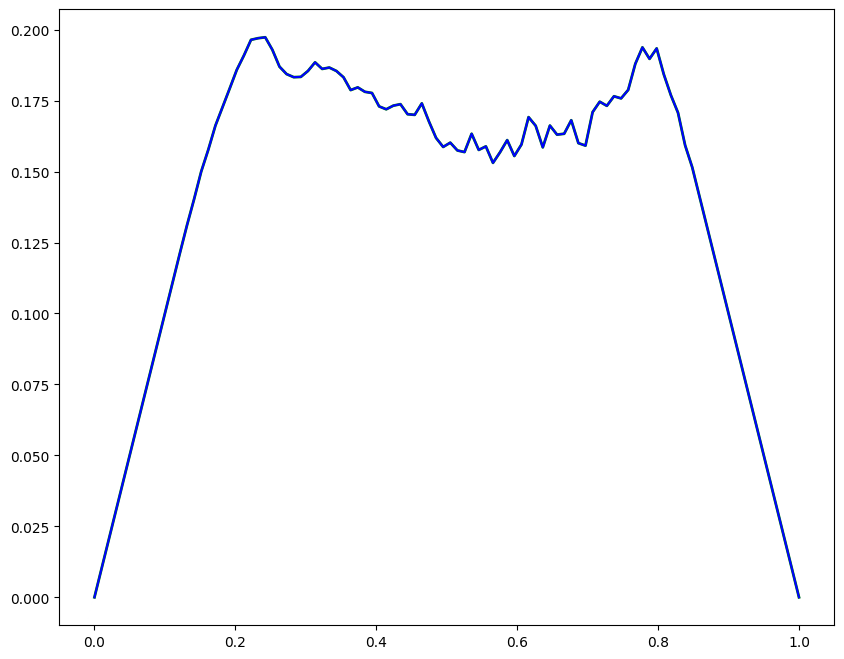

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(prior_values, prior_pred[:, 1]*risks[:,1]+prior_pred[:, 0]*risks[:,0], 'g-', linewidth=2)
plt.plot(xx, r, color='blue', label='Function V')

In [23]:
from dbc.utils import compute_prior_best
compute_prior_best(X_train, y_train, SPDBC.loss_function, SPDBC.p_hat, SPDBC.membership_degree, SPDBC.prior)

Converged after 24 iterations.


array([0.60273097, 0.39726903])

In [24]:
SPDBC.prior

array([0.71428571, 0.28571429])